In [1]:
!hostname

geronimo


In [2]:
!pwd

/Users/johntwo/Documents/github/jcpayne/tanzania_dev/AML


In [3]:
# Check core SDK version number
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Environment, Experiment, Model
from azureml.core.run import Run
from azureml.core.runconfig import RunConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute, RemoteCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.estimator import Estimator
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.data.datapath import DataPath

#Other stuff
import os
import glob
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
print("SDK version:", azureml.core.VERSION)

SDK version: 1.16.0


In [ ]:
#Get workspace from config file
# from azureml.core.workspace import Workspace
# ws = Workspace.from_config()

## Reminder: Detectron2 version issues
The version of Detectron2 that I run on the AML cluster used to be behind the one I ran on the VM on my account (Spearhead3), so model weights were not transferable between the cluster and Spearhead3.  I could't update the cluster version because the cluster machines use CUDA 10.1.  However, I think that problem was solved when I created Spearhead4, which also uses CUDA 10.1.

**Differences between versions of Detectron2:**  
- This (older) version uses TransformGen, which has been renamed to Augmentation in the newer version on Spearhead3.

In [ ]:
#These are for jp_workspace2 workspace (on my subscription)
# mlsubscription = '6c7f51dc-3592-4952-bf04-f7b2d747bfca'
# mlresourcegroup = 'bluedot'
# mlworkspace = 'jp_workspace2'
# mlworkspace_id = '4216f2b3-8583-4de1-b82f-7ddd881e0c06'
# mlstorage = 'jpworkspstoraged93d1a920'
# mlcontainerregistry = jpworkspacea09a28ea' 
# full_mlcontainerregistry = 'jpworkspacea09a28ea.azurecr.io' 
# mlkeyvault = 'jpworkspkeyvault90416cdf'
# aad_tenant = 'fa6e2e1c-81e4-4c48-acd3-c5b7f67420fd'

In [4]:
#These are for jp_hf_aml workspace (on Howard's subscription)
mlsubscription = '528b5ce2-966d-424e-9231-53549c3663e3'
mlresourcegroup = 'jp_hf_aml'
mlworkspace = 'aisurvey_aml'
mlstorage = 'aisurveyaml7764328137'
mlcontainerregistry = 'c7ee859dbf144180b5d2526f88375e0c' 
full_mlcontainerregistry = 'c7ee859dbf144180b5d2526f88375e0c.azurecr.io' 
aad_tenant = 'e44c6d48-04d6-4af1-a825-10bb824d9505'

In [5]:
interactive_auth = InteractiveLoginAuthentication(tenant_id = aad_tenant)

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [6]:
ws = Workspace.get(mlworkspace, auth=interactive_auth, subscription_id=mlsubscription, resource_group=mlresourcegroup)
ws.get_details() #shows registry among other things

{'id': '/subscriptions/528b5ce2-966d-424e-9231-53549c3663e3/resourceGroups/jp_hf_aml/providers/Microsoft.MachineLearningServices/workspaces/aisurvey_aml',
 'name': 'aisurvey_aml',
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': 'c7ee859d-bf14-4180-b5d2-526f88375e0c',
 'sdkTelemetryAppInsightsKey': 'f5784ccd-178d-4ecc-9998-b05841b44ae9',
 'description': '',
 'friendlyName': 'aisurvey_aml',
 'creationTime': '2020-08-26T21:25:33.6299880+00:00',
 'containerRegistry': '/subscriptions/528b5ce2-966d-424e-9231-53549c3663e3/resourceGroups/jp_hf_aml/providers/Microsoft.ContainerRegistry/registries/c7ee859dbf144180b5d2526f88375e0c',
 'keyVault': '/subscriptions/528b5ce2-966d-424e-9231-53549c3663e3/resourcegroups/jp_hf_aml/providers/microsoft.keyvault/vaults/aisurveyaml5091041639',
 'applicationInsights': '/subscriptions/528b5ce2-966d-424e-9231-53549c3663e3/resourcegroups/jp_hf_aml/providers/microsoft.insights/components

In [12]:
# import requests
# x=requests.get('https://management.azure.com/subscriptions/6c7f51dc-3592-4952-bf04-f7b2d747bfca/providers/Microsoft.Compute/skus?api-version=2019-04-01')
#x.json()

### Check workspace and datasets

In [7]:
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')
#ws.get_details()

Workspace name: aisurvey_aml
Azure region: eastus
Subscription id: 528b5ce2-966d-424e-9231-53549c3663e3
Resource group: jp_hf_aml


In [8]:
#List all datastores registered in the current workspace:
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore, datastore.datastore_type)

workspacefilestore {
  "name": "workspacefilestore",
  "container_name": "azureml-filestore-c7ee859d-bf14-4180-b5d2-526f88375e0c",
  "account_name": "aisurveyaml7764328137",
  "protocol": "https",
  "endpoint": "core.windows.net"
} AzureFile
workspaceblobstore {
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-c7ee859d-bf14-4180-b5d2-526f88375e0c",
  "account_name": "aisurveyaml7764328137",
  "protocol": "https",
  "endpoint": "core.windows.net"
} AzureBlob


### OPTIONAL: Check the image data
1. You can see what files are in the folder using Microsoft Storage Explorer
2. The following commands are slow to execute, but the number of filenames should match the size of the temp directory (in Storage Explorer, right-click on the folder and then "Selection Statistics").

In [ ]:
#Warning -- these are SLOW to execute
#fs= image_ds.to_path() #Get all filenames
#Make sure I have the dataset needed (this is a repeat of above)
image_ds = Dataset.get_by_name(ws, name='image_ds') #or Dataset.get_by_id(ws,id)
#Count filenames
#len(image_ds.to_path()) #15602
#Take a sample of 5
image_ds.take(5).to_path()

## Make sure that newly-tiled images are in blobstore
See `aml-pipeline_tanzania.ipynb` for details; remember that you only have to do tiled images and annotations; the originals don't matter for the model

### OPTIONAL: Remake a dataset if necessary

In [106]:
#REMAKE A DATASET
# # retrieve an existing datastore in the workspace by name
datastore = Datastore.get(ws, 'workspaceblobstore')

# #A "FileDataset" is really just a name for a blob, and nothing happens until it's mounted.
# #Once it's mounted, then you have to use other tools to get its paths 
# #Define a FileDataset for the temp directory, which has subdirectories
datastore_paths = [(datastore, 'temp')]
image_ds = Dataset.File.from_files(path=datastore_paths)
# #Register it 
image_ds.register(workspace=ws,
                     name='image_ds',
                     description='tanzania main folder temp',
                     create_new_version=True)

In [8]:
#Define a datastore for output
#datastore = Datastore.get(ws, datastore_name='workspaceblobstore')


In [ ]:
#Upload either a directory or individual files to the datastore by using the Python SDK:
# datastore.upload(src_dir='your source directory',
#                  target_path='your target path',
#                  overwrite=True,
#                  show_progress=True)
#The target_path parameter specifies the location in the file share (or blob container) to upload. 
#It defaults to None, so the data is uploaded to root. If overwrite=True, any existing data at target_path is overwritten.
#You can also upload a list of individual files to the datastore via the upload_files() method.


## Deploy a cluster
Note: this will check to see if a cluster is already running before creating one.  If it finds a cluster of the same name, it will use it instead of creating a new cluster.

Also, if you go to the Compute tab in Studio, you can edit the properties such as the minimum nodes (if 0, the cluster will power down when finished; if 1 it will stay alive).

In [ ]:
#Get a list of supported VM sizes in your region (you'll need the name for the cluster)
AmlCompute.supported_vmsizes(ws, location='eastus') #or 'westus2'

In [9]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    mycompute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    #max_nodes is the number of VMs you are creating
    #Try NC24r_Promo
    compute_config = AmlCompute.provisioning_configuration(
        vm_size= 'Standard_NC24rs_v3', #'STANDARD_NC6', #'Standard_NC24rs_v2','Standard_NC24r','STANDARD_NC12S_V2',#'Standard_NC24r',
        min_nodes = 0,#SET TO 0 FOR IT TO AUTO-STOP, OR TO 1 to keep alive
        max_nodes=1) 

    # create the cluster
    mycompute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
    #In the estimator, you'll specify
    #estimator = Estimator(...compute_target=my_compute_target,...)

    mycompute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
# print(mycompute_target.get_status().serialize())

#WAIT for it to say "Minimum number of nodes requested have been provisioned"

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [43]:
#OPTIONAL: if you need to delete one
mycompute_target.delete()

## Attach VM instead of cluster
**REMINDER -- Spearhead3 uses CUDA v10.2 whereas the containerized code uses CUDA v10.1, so Spearhead3 should not be used for model training because the weights may not be transferrable.**

In [31]:
# from azureml.core.compute import RemoteCompute, ComputeTarget

# # Create the compute config 
# compute_target_name = "spearhead3"
# #Create the resource_id
# #/subscriptions/<subscription_id>/resourceGroups/<resource_group>/providers/Microsoft.Compute/virtualMachines/<vm_name>
# resource_id = '/subscriptions/6c7f51dc-3592-4952-bf04-f7b2d747bfca/resourceGroups/bluedot/providers/Microsoft.Compute/virtualMachines/spearhead3'
# attach_config = RemoteCompute.attach_configuration(resource_id=resource_id,
#     ssh_port=22,
#     username='egdod',
# #    password=None,
#     private_key_file="/Users/johntwo/.ssh/azure_rsa")
#     #private_key_passphrase="<passphrase>")

# # For password access instead of ssh
# # attach_config = RemoteCompute.attach_configuration(resource_id='<resource_id>',
# #                                                 ssh_port=22,
# #                                                 username='<username>',
# #                                                 password="<password>")

# # Attach the compute
# spearhead3_compute_target = ComputeTarget.attach(ws, compute_target_name, attach_config)

# #compute.wait_for_completion(show_output=True)

## Create or get an experiment

In [10]:
#This "gets OR creates" an experiment; i.e., if it already exists, it will return the existing one
#from azureml.core import Experiment

experiment_name = 'jphf_expt4'
experiment = Experiment(ws, name=experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
jphf_expt4,aisurvey_aml,Link to Azure Machine Learning studio,Link to Documentation


### OPTIONAL: Register environment (if new)

In [108]:
trident_env = Environment(name="trident") #Instantiate an Environment object
trident_env.python.user_managed_dependencies = True
trident_env.docker.enabled = True
trident_env.docker.base_image = 'tridentbase:v13'
trident_env.docker.base_image_registry.address = full_mlcontainerregistry
trident_env.inferencing_stack_version='latest'
#Get the existing conda dependencies
#conda_dep = trident_env.python.conda_dependencies
#conda_dep.add_pip_package("imgaug")
#conda_dep.add_pip_package("adabound")
#azureml-defaults seems to be added automatically, even if you don't include it anywhere

#Register the environment
trident_env.register(ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "tridentbase:v13",
        "baseImageRegistry": {
            "address": "c7ee859dbf144180b5d2526f88375e0c.azurecr.io",
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": "latest",
    "name": "trident",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
         

### Get a registered environment

In [11]:
trident_env = Environment.get(ws,"trident")

In [12]:
#Make sure I have the dataset needed (this is a repeat of above)
image_ds = Dataset.get_by_name(ws, name='image_ds') #or Dataset.get_by_id(ws,id)

In [13]:
mycompute_target

AmlCompute(workspace=Workspace.create(name='aisurvey_aml', subscription_id='528b5ce2-966d-424e-9231-53549c3663e3', resource_group='jp_hf_aml'), name=gpu-cluster, id=/subscriptions/528b5ce2-966d-424e-9231-53549c3663e3/resourceGroups/jp_hf_aml/providers/Microsoft.MachineLearningServices/workspaces/aisurvey_aml/computes/gpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=eastus, tags=None)

### Resume or not?
>"If `resume==True` and `cfg.OUTPUT_DIR` contains the last checkpoint (defined by a last_checkpoint file), resume from the file. **Resuming means loading all available states (eg. optimizer and scheduler) and update iteration counter from the checkpoint.** `cfg.MODEL.WEIGHTS` will not be used." 

(I think because model weights are included in the checkpoint).

>"Otherwise, this is considered as an independent training. The method will load model weights from the file `cfg.MODEL.WEIGHTS` (but will not load other states) and start from iteration 0."

In [14]:
# def_blob_store = Datastore(ws, "workspaceblobstore")

# input_data = DataReference(
#     datastore=def_blob_store,
#     data_reference_name="input_data",
#     path_on_datastore="20newsgroups/20news.pkl")


#These are literally command-line parameters to be used with the main .py script file when it is called.
#Note 1: as_named_input() looks for a dataset registered to the workspace under that name
#Note 2: "data_folder at this stage is a "DatasetConsumptionConfig" object.  It gets converted during the run to a directory name.
script_params = {
    # Mount image_ds and pass the mount point name as the data folder argument 
    '--data_folder': image_ds.as_named_input('image_ds').as_mount(),
    '--resume': None, #--resume: None means resume=True (but the latter fails).  Set false to start fresh.
    '--output_dir':  './outputs',
    '--num_gpus_per_machine':4,
    '--num_machines':1,
    '--machine_rank':0,
    '--dist_url':"auto" #,
    #'--eval_only':None #Will trigger evaluation if present ('None' is necessary -- 'True' fails)
}

#Note: I created a symlink in /AML to the dev_packages folder in ../trident_project; hopefully it works.
project_folder = '/Users/johntwo/Documents/github/jcpayne/tanzania_dev/trident_project' #testing_aml_workflow
est = Estimator(source_directory=project_folder,
              script_params=script_params,
              compute_target=mycompute_target,
              environment_definition=Environment.get(workspace=ws,name="trident"),
              entry_script='trident_run_and_inference.py')

# estimator = Estimator(source_directory=project_folder,
#                       compute_target=compute_target,
#                       entry_script='./scripts/test_predict.py',
#                       script_params=script_params,
#                       node_count=1,
#                       process_count_per_node=1,
#                       distributed_backend='mpi',
#                       pip_packages=['cntk-gpu==2.6'],
#             THIS NEXT LINE MUST REFER TO AN IMAGE THAT WAS REGISTERED WITH THE WORKSPACE CONTAINER REGISTRY
#                       custom_docker_image='microsoft/mmlspark:gpu-0.12',
#                       use_gpu=True)


### Did you copy the weights over AND double-check the filename in test_predict.py?
Using Azure Storage Explorer:   
- go to the usual `azureml-blobstore_etc`, 
- then to `azureml`, 
- then find the run you want (usually on pg 2 -- look for where the folders end), 
- then copy `model_final.pth` into `azureml-blobstore_etc/temp` (NOT outside `temp`!).  Moving doesn't work.

In [15]:
run = experiment.submit(est)

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


In [21]:
#Get the runId of the current run so you can load it later
run.get_details()['runId']


'jphf_expt4_1607636510_71a62033'

In [ ]:
#Then come back tomorrow and see how it's doing:
run = Run(exp, 'mdv4_trial_1580850141_379ed8f0')
run.get_status()

In [16]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
aisurvey_expt3,aisurvey_expt3_1596516492_d166fa2f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
run.cancel

<bound method ScriptRun.cancel of Run(Experiment: aisurvey_expt6,
Id: aisurvey_expt6_1597559582_c2a72f75,
Type: azureml.scriptrun,
Status: Starting)>

In [28]:
#Live-stream logs (every 10-15 seconds)
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [ ]:
#model = run.register_model(model_name='pt-dnn', model_path='outputs/')

## Assess training progress

#### Understanding the Detectron2 output
Reminder: don't interpret the slash in the name as division: it just identifies a model component.  For example, `fast_rcnn/cls_accuracy` means the "class accuracy of the RCNN"
- `fast_rcnn/cls_accuracy` = num_accurate / num_instances (Want this to be 1)
- `fast_rcnn/fg_cls_accuracy` = fg_num_accurate / num_fg (Want this to be 1)
- `fast_rcnn/false_negative` = num_false_negative / num_fg) (Want this to be zero)
- `roi_head/num_fg_samples` The number of fg samples that are selected for training ROI heads =mean(num_fg_samples)
- `roi_head/num_bg_samples` The number of bg samples that are selected for training ROI heads =mean(num_bg_samples)
- `rpn/num_pos_anchors` the number of positive anchors per-image used in training = num_pos_anchors/num_images
- `rpn/num_neg_anchors` the number of negative anchors per-image used in training = num_neg_anchors/num_images


### Accessing run output
#### From the portal
You can check output simply by typing:
```python
run
#or
experiment
```
#### From a notebook or script
```python
# access the run id for use later
run_id = run.id

#Attach to a run
fetched_run = Run(<experiment>, run_id)
#or
fetched_run = <experiment>.get_runs(<run_id>) #Check the argument -- I'm guessing

#Get all run metrics
fetched_run.get_metrics()

#Get a particular metric
fetched_run.get_metrics(name = "scale factor")

#Get the filenames of files that were uploaded to the run
fetched_run.get_file_names()

#Download those files to your local machine
import os
os.makedirs('files', exist_ok=True)

for f in run.get_file_names():
    dest = os.path.join('files', f.split('/')[-1]) #using just the filename and dropping the path
    print('Downloading file {} to {}...'.format(f, dest))
    fetched_run.download_file(f, dest)
```

In [16]:
#This doesn't show metrics because Detectron stores them in metrics.json, which is only available after the run.
run.get_metrics()

{'Data folder': '/tmp/tmpq86gb_ai',
 'annotationpath': "PosixPath('/tmp/tmpq86gb_ai/tiled_annotations')",
 'test': 100,
 'rootdir': "PosixPath('/tmp/tmpq86gb_ai')",
 'test_list': [1, 2, 3],
 'imagepath': "PosixPath('/tmp/tmpq86gb_ai/tiled_images')",
 'output_dir': './outputs',
 'Class names': ['giraffe',
  'building',
  'cow',
  'human',
  'impala',
  'buffalo',
  'elephant',
  'boma',
  'shoats',
  'zebra',
  'donkey',
  'wildebeest',
  'oryx',
  'charcoal sack',
  'charcoal mound',
  'eland',
  'kudu',
  'hartebeest',
  'gazelle'],
 'survey_valid': "Metadata(name='survey_valid', thing_classes=['giraffe', 'building', 'cow', 'human', 'impala', 'buffalo', 'elephant', 'boma', 'shoats', 'zebra', 'donkey', 'wildebeest', 'oryx', 'charcoal sack', 'charcoal mound', 'eland', 'kudu', 'hartebeest', 'gazelle'])"}

In [ ]:
#Get files associated with the run
print(run.get_file_names())

## Where the hell are my output files?
Answer: use the Microsoft Azure Storage Explorer.  It's in:
- `azureml-blobstore-84d56c80-a8c3-4b14-a1fa-0dde9dadda0d/azureml/<run_results>/outputs`  
For `<run_results>`, choose one of the folders, noting that:   
1. The files are in backwards date order (oldest on top)
2. There are TWO folders for each run; one of them has a name that ends in '-setup' and the other is the results
3. There are also two files per run; one is a zip and the other has 0 bytes; I think the zip probably has everything but I haven't checked.

## Register the model
This makes the workspace track it and version it.  It's also a step necessary for deployment.  There's nice documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-train-models-with-aml) and in part 2 of the same tutorial they do deployment.

The `model_path` parameter takes in the relative path on the remote VM to the model file in your `outputs` directory. 

In [15]:
from azureml.core.model import Model
# Tip: When model_path is set to a directory, you can use the child_paths parameter to include
#      only some of the files from the directory
# model = Model.register(model_path = "./models",
#                        model_name = "sentiment",
#                        description = "Sentiment analysis model trained outside Azure Machine Learning",
#                        workspace = ws)
# Register model
model = run.register_model(model_name='tridentmodel_expt7_run1',
                           model_path='outputs/model_final.pth',
                           description = "Expt7_run1 on 25K dataset v2s 21Aug2020")
print(model.name, model.id, model.version, sep='\t')

tridentmodel_expt7_run1	tridentmodel_expt7_run1:1	1


## Parse the JSON metrics file so we can plot it

In [16]:
import json
traindir = Path('/Users/johntwo/Documents/tanzania_project/training_history/training_on_800x800')

run5 = {'runmetricsfile': traindir/'metrics_run5_2020dec10.json', 'training_time_h': 0.78, 'nreps': 500, 'max_lr': 0.0005}
run7 = {'runmetricsfile': traindir/'metrics_run7_2020dec10.json', 'training_time_h': 0.8, 'nreps': 500, 'max_lr': 0.005}
run8 = {'runmetricsfile': traindir/'metrics_run8_2020dec10.json', 'training_time_h': 1.39, 'nreps': 1000, 'max_lr': 0.0005}
run10 = {'runmetricsfile': traindir/'metrics_run10_2020dec10.json', 'training_time_h': 3.77, 'nreps': 7500, 'max_lr': 0.0005}
run11 = {'runmetricsfile': traindir/'metrics_run11_2020dec11.json', 'training_time_h': 7.15, 'nreps': 18000, 'max_lr': 0.0004}
run12 = {'runmetricsfile': traindir/'metrics_run12_2020dec11.json', 'training_time_h': 9.45, 'nreps': 25000, 'max_lr': 0.0003}
run15 = {'runmetricsfile': traindir/'metrics_run15_2020dec12.json', 'training_time_h': 5.35, 'nreps': 12500, 'max_lr': 0.0005}
run16 = {'runmetricsfile': traindir/'metrics_run16_2020dec12.json', 'training_time_h': 3.78, 'nreps': 7500, 'max_lr': 0.0001}
run17 = {'runmetricsfile': traindir/'metrics_run17_2020dec13.json', 'training_time_h': 8.47, 'nreps': 22000, 'max_lr': 0.0003}
run18 = {'runmetricsfile': traindir/'metrics_run18_2020dec14.json', 'training_time_h': 7.83, 'nreps': 20000, 'max_lr': 0.0003}


runlist = [run5, run7, run8, run10, run11, run12,run15,run16, run17,run18]
training_df = pd.DataFrame(runlist)
sum(training_df['training_time_h'])
training_files = list(training_df['runmetricsfile'])
training_df

,runmetricsfile,training_time_h,nreps,max_lr
0,/Users/johntwo/Documents/tanzania_project/trai...,0.78,500,0.0005
1,/Users/johntwo/Documents/tanzania_project/trai...,0.80,500,0.0050
2,/Users/johntwo/Documents/tanzania_project/trai...,1.39,1000,0.0005
3,/Users/johntwo/Documents/tanzania_project/trai...,3.77,7500,0.0005
4,/Users/johntwo/Documents/tanzania_project/trai...,7.15,18000,0.0004
5,/Users/johntwo/Documents/tanzania_project/trai...,9.45,25000,0.0003
6,/Users/johntwo/Documents/tanzania_project/trai...,5.35,12500,0.0005
7,/Users/johntwo/Documents/tanzania_project/trai...,3.78,7500,0.0001
8,/Users/johntwo/Documents/tanzania_project/trai...,8.47,22000,0.0003
9,/Users/johntwo/Documents/tanzania_project/trai...,7.83,20000,0.0003


In [17]:
#How much have I spent?  The v3 x4GPU machine costs $12.24/hour
training_hours = sum(training_df['training_time_h'])
cost = 12.24 * training_hours
print('Total training hours: ',training_hours,'; NC machine cost: $', cost)

Total training hours:  48.769999999999996 ; NC machine cost: $ 596.9448


In [18]:
metdata = []
n = 0
for metricsfile in training_files:
    mfile = open(metricsfile, 'r')
    lines = mfile.readlines()
    mfile.close()

    for i in range(len(lines)):
        n += 20
        ld = json.loads(lines[i])
        ld['iter_global'] = n
        metdata.append(ld)

        
metdf = pd.DataFrame(metdata)
metdf

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss,iter_global
0,0.013301,794.674704,0.985107,0.465385,0.488462,19,0.075054,0.067366,0.049097,0.010797,0.000095,498.250,13.750,251.750,4.250,1.652130,0.226657,20
1,0.011935,761.792405,0.975098,0.621744,0.363427,39,0.080767,0.075145,0.061079,0.014820,0.000195,495.250,16.750,251.750,4.250,1.653937,0.234080,40
2,0.015964,729.942745,0.990967,0.548270,0.297381,59,0.061944,0.082387,0.055674,0.009724,0.000295,506.000,6.000,254.625,1.375,1.659671,0.212170,60
3,0.015608,697.452950,0.977051,0.697826,0.128103,79,0.065302,0.111999,0.053259,0.011172,0.000395,498.500,13.500,251.625,4.375,1.664979,0.244921,80
4,1.028702,664.663739,0.984619,0.953571,0.000000,99,0.079754,0.140340,0.055127,0.013489,0.000495,503.875,8.125,252.875,3.125,2.664295,0.331897,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,0.007601,94.664582,0.991455,0.152899,0.838235,19919,0.067755,0.036527,0.007070,0.008345,0.000030,496.375,15.625,253.000,3.000,1.166957,0.116734,114400
5720,0.007643,71.297991,0.990967,0.121545,0.850000,19939,0.060846,0.034770,0.005025,0.005271,0.000030,490.375,21.625,252.125,3.875,1.171848,0.111881,114420
5721,0.007908,47.924382,0.989746,0.144599,0.830939,19959,0.061146,0.034342,0.006180,0.006549,0.000030,496.250,15.750,252.125,3.875,1.169436,0.100888,114440
5722,0.008162,24.550582,0.991943,0.122551,0.875388,19979,0.065389,0.031171,0.005719,0.006607,0.000030,496.500,15.500,252.750,3.250,1.167876,0.104887,114460


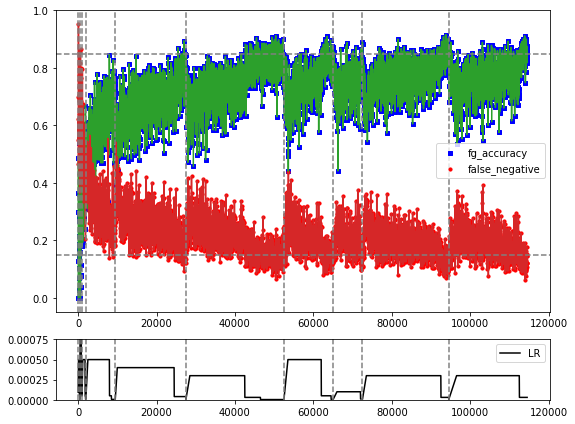

In [21]:
#Define x and three y series
x = metdf['iter_global']    #.iteration
y1 = metdf['fast_rcnn/fg_cls_accuracy']
y2 = metdf['fast_rcnn/false_negative']
y3 = metdf.lr

gs = gridspec.GridSpec(2,1, height_ratios=[5, 1])
fig = plt.figure(figsize=(8, 6)) 
ax1 = plt.subplot(gs[0])
ax1.scatter(x,y1, s=10, c='b', marker="s", label='fg_accuracy')
ax1.scatter(x,y2, s=10, c='r', marker="o", label='false_negative')
ax1.legend(loc='center right');
ax1.plot(x, y1, color='tab:green')
ax1.plot(x,y2,color='tab:red')
ax1.axhline(y=0.15, color='gray',linestyle = 'dashed')
ax1.axhline(y=0.85, color='gray',linestyle = 'dashed')

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
ax2.plot(x,y3, color='black',label='LR')
ax2.legend(loc='upper right')
ax2.set_ylim([0, .00075])

#Create a set of vertical lines to show where each restart is
vlines = list(metdf[metdf['iteration']==19]['iter_global'])
for i in range(len(vlines)):
    ax1.axvline(x=vlines[i], color='gray',linestyle = 'dashed')
    ax2.axvline(x=vlines[i], color='gray',linestyle = 'dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



In [177]:
vlines

[20, 500, 1000, 2000, 9500, 27500]

# Other Notes

### Adding AdaBound optimizer
"As described in the paper, AdaBound is an optimizer that behaves like Adam at the beginning of training, and gradually transforms to SGD at the end. The final_lr parameter indicates AdaBound would transforms to an SGD with this learning rate. **In common cases, a default final learning rate of 0.1 can achieve relatively good and stable results on unseen data. It is not very sensitive to its hyperparameters.** See Appendix G of the paper for more details."

To AdaBound, I added the following to `test_predict.py`:
1. imports for the `adabound` package
2. imports for some supporting packages in `detectron2.solver.build`
3. A new class method (`build_optimizer`) added to the Trainer class.

Using conda_dep to import the package failed, so I added it to the Docker image instead, which worked, and the changes moved the Docker image on to v5.  
`conda_dep.add_pip_package("adabound") #FAILED`  
See aml-pipeline_tanzania.ipynb for Dockerfile details.

### Try to access Howard's DataShare (testing)

In [159]:
image_ds.get_all(ws)

{'image_ds': DatasetRegistration(id='3f3064ba-5016-4255-90b7-72d4e528e94a', name='image_ds', version=2, description='tanzania main folder temp', tags={})}

In [6]:
image_ds = Dataset.get_by_name(workspace=ws, name='image_ds')

In [ ]:
tanz_ds = Dataset.get_by_name(workspace=ws, name='')

In [162]:
datastore = Datastore.get(ws, 'workspaceblobstore')

In [163]:
datastore

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-84d56c80-a8c3-4b14-a1fa-0dde9dadda0d",
  "account_name": "jpworkspace3957796892",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [154]:
#datastore_paths = 'https://datashare.hosting.portal.azure.net/account/receivedshares/sharesubscriptiondetails#'

#[(datastore, 'surveyimagery_hlf')] #[(datastore, 'sde-images')]

In [155]:
tanz_ds = Dataset.File.from_files(path=datastore_paths)

In [158]:
tanz_ds.take(5).to_path()

['/sharesubscriptiondetails#']

In [ ]:
#https://datashare.hosting.portal.azure.net/account/receivedshares/sharesubscriptiondetails#
#from azureml.core import Workspace, Datastore, Dataset

# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, workspaceblobstore)

# create a TabularDataset from 3 file paths in datastore (note multiple sources: one dataset!)
datastore_paths = [(datastore, 'weather/2018/11.csv'),
                   (datastore, 'weather/2018/12.csv'),
                   (datastore, 'weather/2019/*.csv')] #note wildcard
weather_ds = Dataset.Tabular.from_delimited_files(path=datastore_paths)

# Create a FileDataset from a single source (root directory)
datastore_paths = [(datastore, 'TA25')]
animal_ds = Dataset.File.from_files(path=datastore_paths)

#Create a FileDataset in one step, using wildcards
dataset = Dataset.File.from_files('https://dprepdata.blob.core.windows.net/demo/green-small/*.csv')

# Create a FileDataset from public image and label files (i.e., data at public web urls)
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz']
mnist_ds = Dataset.File.from_files(path=web_paths)

hdata = Dataset.get_by_name(ws,name='sde-images')

## Training loop

- `detectron2/tools/plain_train_net.py` is a fairly fleshed-out version of a training script that you might want to customize.
- `train_net.py` is a simpler version with more default behavior baked in.

The `DefaultTrainer` class has a good layout of everything you'd want to overwrite.  It's in `detectron2/engine/Defaults.py`.  

`DefaultTrainer` calls its superclass `SimpleTrainer`, which is:   
"A simple trainer for the most common type of task: single-cost single-optimizer single-data-source iterative optimization.  It assumes that every step, you:  
1. Compute the loss with a data from the data_loader.  
2. Compute the gradients with the above loss.  
3. Update the model with the optimizer.  
`SimpleTrainer` includes the method `run_step(),` which runs a _single_ step.

All other tasks during training (checkpointing, logging, evaluation, LR schedule) are maintained by hooks, which can be registered by `TrainerBase.register_hooks`."

The actual training _loop_ function is in its superclass, `TrainerBase`.  All `train()` does is step for max_iterations, and processes hooks (`before_step`, `after_step`, etc.).
```python
def train():
    for self.iter in range(start_iter, max_iter):
        self.before_step()
        self.run_step()
        self.after_step()
```



## Delete experiments (script from Azure Support)

In [16]:
import uuid
import requests
from azureml._base_sdk_common.user_agent import get_user_agent
from azureml._base_sdk_common import _ClientSessionId
from azureml.core.experiment import Experiment
from azureml._common.exceptions import AzureMLException
from azureml._restclient.clientbase import ClientBase

def delete_run(workspace, experiment_name, run_id):
    """
    :param workspace:
    :type workspace: azureml.core.workspace.Workspace
    :param experiment_name: experiment name.
    :type experiment_name: str
    :param run_id: run id
    :type run_id: str
    :return:
    """
    
    headers = {
        "User-Agent": get_user_agent(),
        "x-ms-client-session-id": _ClientSessionId,
        "x-ms-client-request-id": str(uuid.uuid4())
    }

    # Merging the auth header.
    headers.update(workspace._auth_object.get_authentication_header())
    experiment = Experiment(workspace, experiment_name)
    rh_workspace_scope = workspace.service_context._get_run_history_url() + "/history/v1.0/private" + workspace.service_context._get_workspace_scope()
    delete_url = rh_workspace_scope + "/" + "experimentids/{}/runs/{}".format(experiment.id, run_id)
    response = ClientBase._execute_func(requests.delete, delete_url, headers=headers)
    
    if response.status_code >= 400:
        from azureml._base_sdk_common.common import get_http_exception_response_string
        # response.text is a JSON from execution service.
        response_message = get_http_exception_response_string(response)
        raise AzureMLException(response_message)
    result = response.json()
    print(result)


In [19]:
#Retrieved from Azure Machine Learning web UI
#run_id = 'aaaaaaaa-bbbb-cccc-dddd-0123456789AB'
#aisurvey_expt: 9 runs
#aisurvey_expt2: 27 runs
#aisurvey_expt3: 30 runs
#aisurvey_expt4: 21 runs

#List experiments
[ex for ex in ws.experiments]
# ['aisurvey_expt5',
#  'aisurvey_expt6',
#  'aisurvey_expt',
#  'aisurvey_expt2',
#  'aisurvey_expt3',
#  'aisurvey_expt4']

experiment_name = 'aisurvey_expt2'
exp = ws.experiments[experiment_name]
for run in exp.get_runs():
    #print(run.id)
    #delete_run(ws, experiment_name, run.id)
    run.clean()